In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlptools.io.read import read_from_format

all_scf_dirs = []
path2scf = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902"
all_scf_dirs.extend(glob(f'{path2scf}/scf*'))

path2scf = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-546794/send_20230902"
all_scf_dirs.extend(glob(f'{path2scf}/scf*'))

In [2]:
import re
def get_mpid_from_path(path):
    match = re.search(r"mp-\d+", path)
    if match:
        result = match.group(0)
    else:
        result = None
    return result

all_atoms = []
for path in all_scf_dirs:
    mpid = get_mpid_from_path(path)
    try:
        all_atoms.append(read_from_format(
            path2target=path,
            format='espresso-in',
            structure_id=mpid
        ))
    except Exception as e:
        print(f"[Error] {path}: {e}")
        continue

[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_29056: invalid: job didnot finished
[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_11668: invalid: job didnot finished
[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_15455: invalid: job didnot finished
[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_14142: invalid: job didnot finished
[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_19662: invalid: job didnot finished
[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_28468: invalid: job didnot finished
[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_24869: invalid: job didnot finished
[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_8734: invalid: job didnot finished
[Error] /Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/send_20230902/scf_9028: invalid: job d

# Energy distribution

In [3]:
atoms_energy_dict = {
    "structure_id": [],
    "total_energy": [],
    "n_atoms": [],
    "volume": [],
    "energy_per_atom": [],
    "volume_per_atom": []
}
for atoms in all_atoms:
    atoms_energy_dict["structure_id"].append(atoms.structure_id)
    atoms_energy_dict["total_energy"].append(atoms.energy)
    atoms_energy_dict["n_atoms"].append(atoms.n_atoms)
    atoms_energy_dict["volume"].append(atoms.get_volume())
    atoms_energy_dict["energy_per_atom"].append(atoms.energy / atoms.n_atoms)
    atoms_energy_dict["volume_per_atom"].append(atoms.get_volume() / atoms.n_atoms)

In [4]:
atoms_energy_df = pd.DataFrame.from_dict(atoms_energy_dict)

# plot energy distribution

<Axes: xlabel='volume_per_atom', ylabel='energy_per_atom'>

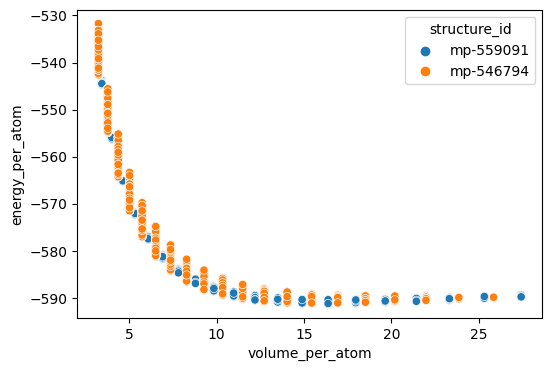

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=atoms_energy_df,
    x="volume_per_atom",
    y="energy_per_atom",
    hue="structure_id",
    ax=ax
)

# Force distribution

In [6]:
atoms_force_dict = {
    "structure_id": [],
    "force_x": [],
    "force_y": [],
    "force_z": [],
}
for atoms in all_atoms:
    atoms_force_dict["structure_id"].extend(atoms.structure_id for _ in range(atoms.n_atoms))
    atoms_force_dict["force_x"].extend(atoms.force[:, 0])
    atoms_force_dict["force_y"].extend(atoms.force[:, 1])
    atoms_force_dict["force_z"].extend(atoms.force[:, 2])

<Axes: xlabel='force_x', ylabel='force_y'>

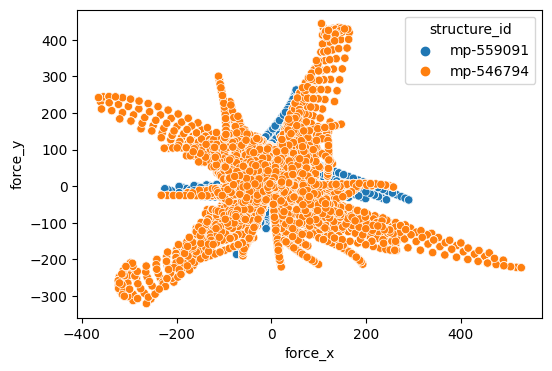

In [7]:
atoms_force_df = pd.DataFrame.from_dict(atoms_force_dict)

# plot force distribution
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=atoms_force_df,
    x="force_x",
    y="force_y",
    hue="structure_id",
    ax=ax
)

# RDF

In [37]:
rdf_mean_std_dict = {}

for atoms in all_atoms[:10]:
    rdf = atoms.get_rdf_for_multiple_species()
    for key in rdf.keys():
        if key not in rdf_mean_std_dict.keys():
            rdf_mean_std_dict[key] = []
        rdf_mean_std_dict[key].append(rdf[key])

for key in rdf_mean_std_dict.keys():
    rdf_val_matrix = np.array(rdf_mean_std_dict[key])
    rdf_mean_std_dict[key] = {}
    rdf_mean_std_dict[key]["val"] = rdf_val_matrix
    rdf_mean_std_dict[key]["mean"] = np.mean(rdf_val_matrix, axis=0)
    rdf_mean_std_dict[key]["std"] = np.std(rdf_val_matrix, axis=0)

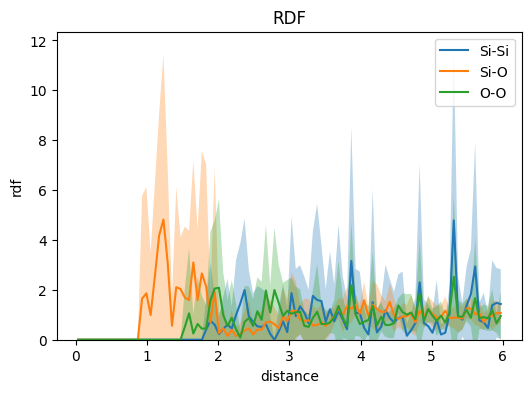

In [43]:
# RDFを全て一緒にプロットする
fig, ax = plt.subplots(figsize=(6, 4))
for key in rdf_mean_std_dict.keys():
    if key == "distance":
        continue
    rdf_mean = rdf_mean_std_dict[key]["mean"]
    rdf_std = rdf_mean_std_dict[key]["std"]
    rdf_distance = rdf_mean_std_dict["distance"]["mean"]

    ax.plot(rdf_distance, rdf_mean, label=key)
    ax.fill_between(rdf_distance, rdf_mean-rdf_std, rdf_mean+rdf_std, alpha=0.3)

ax.set_title("RDF")
ax.set_xlabel("distance")
ax.set_ylabel("rdf")

ax.set_ylim(0,)
ax.legend()

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_79183/403849621.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


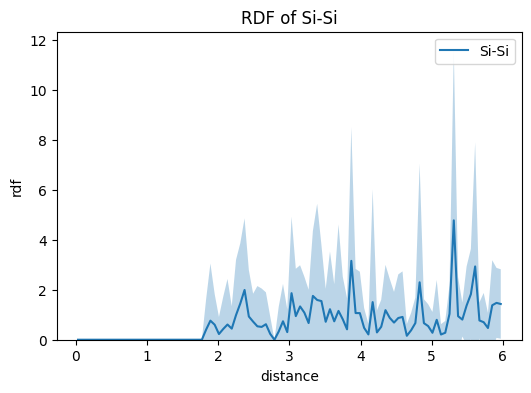

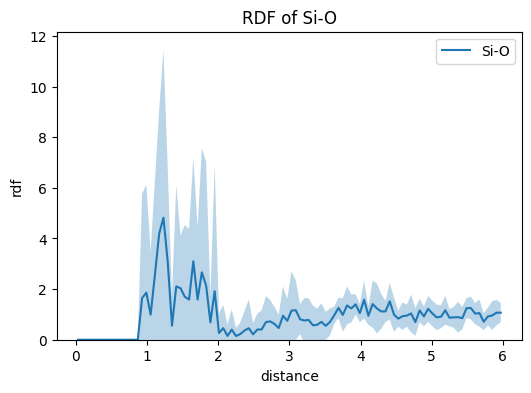

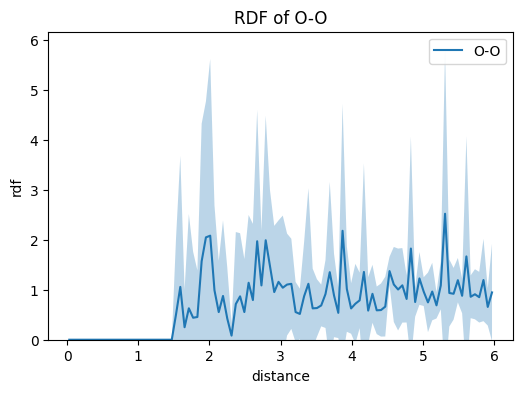

In [44]:
# RDFを原子種ごとにプロットする
for key in rdf_mean_std_dict.keys():
    if key == "distance":
        continue
    rdf_mean = rdf_mean_std_dict[key]["mean"]
    rdf_std = rdf_mean_std_dict[key]["std"]
    rdf_distance = rdf_mean_std_dict["distance"]["mean"]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(rdf_distance, rdf_mean, label=key)
    ax.fill_between(rdf_distance, rdf_mean-rdf_std, rdf_mean+rdf_std, alpha=0.3)

    ax.set_title(f"RDF of {key}")
    ax.set_xlabel("distance")
    ax.set_ylabel("rdf")

    ax.set_ylim(0,)
    ax.legend()
    fig.show()